<a href="https://colab.research.google.com/github/zw2497/Large_Stream_Processing/blob/master/large_data_optimization_reordering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Java, Spark, and Findspark
This installs Apache Spark 2.4.0, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-eu.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install findspark

#### Set Environment Variables
Set the locations where Spark and Java are installed.

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

# Start a SparkSession
This will start a local Spark session.

In [0]:
import time
import re
import math
import numpy as np

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

spark = SparkSession \
    .builder \
    .appName("StructuredNetworkWordCount") \
    .getOrCreate()

## Download Dataset

In [0]:
!wget -q https://github.com/zw2497/Large_Stream_Processing/releases/download/v1.0/epa-http.txt

## Load Dataset

In [0]:
df = spark.read.load("/content/epa-http.txt", format="text")

## Check dataset

In [7]:
df.show(truncate=False)
df.printSchema()

+----------------------------------------------------------------------------------------------------------------+
|value                                                                                                           |
+----------------------------------------------------------------------------------------------------------------+
|141.243.1.172 [29:23:53:25] "GET /Software.html HTTP/1.0" 200 1497                                              |
|query2.lycos.cs.cmu.edu [29:23:53:36] "GET /Consumer.html HTTP/1.0" 200 1325                                    |
|tanuki.twics.com [29:23:53:53] "GET /News.html HTTP/1.0" 200 1014                                               |
|wpbfl2-45.gate.net [29:23:54:15] "GET / HTTP/1.0" 200 4889                                                      |
|wpbfl2-45.gate.net [29:23:54:16] "GET /icons/circle_logo_small.gif HTTP/1.0" 200 2624                           |
|wpbfl2-45.gate.net [29:23:54:18] "GET /logos/small_gopher.gif HTTP/1.0" 200 935

## Register a parse UDF

In [8]:
def parse(x,n):
    res = re.findall(r"([^\s]+)\s\[([^\s]+)\]\s\"(.+)\"\s(\w+)\s(\w+)", x)
    return res[0][n].strip() if len(res)>=1 else ""

spark.udf.register("parse", parse)

<function __main__.parse>

# OPERATOR REORDERING
This is an implementation of [A Catalog of Stream Processing Optimizations](https://dl.acm.org/citation.cfm?id=2528412)
The dataset is a sample from [Internet Traffic Archive](http://ita.ee.lbl.gov/html/traces.html)


The experiment shows throughput given two operators A and B of equal cost, where the selectivity of A is fixed at 0.5, and the selectivity of B varies on the x-axis. Assume that the drop probabilities of A and B are independent. If A comes before B, then no matter what the selectivity of B is, A processes all data and B processes 50% of the data, so the performance does not change. If B comes before A, then B processes all data, but the amount of data processed by A is determined by the selectivity of B, and overall throughput is higher when B drops more data. The cross-over point is when both are equally selective.

![alt text](https://github.com/zw2497/Large_Stream_Processing/raw/master/WX20190310-154157%402x.png)

## Parse raw data

In [9]:
%%time
q = """SELECT parse(value,0) as ipaddr,  parse(value,4) as size FROM t"""
df.createOrReplaceTempView("t")
df1 = spark.sql(q)

CPU times: user 2.04 ms, sys: 9 µs, total: 2.05 ms
Wall time: 505 ms


## Set selectivity

In [10]:
selectivity = np.linspace(0.01, 1, 9)
selectivity

array([0.01   , 0.13375, 0.2575 , 0.38125, 0.505  , 0.62875, 0.7525 ,
       0.87625, 1.     ])

## Define operation A and B

In [0]:
A = """SELECT T1.ipaddr, T1.size 
FROM t as T1, t as T2 
where T1.ipaddr = T2.ipaddr and T1.size % 2 = 0"""

B = """SELECT T1.ipaddr, T1.size 
FROM t as T1, t as T2 
where T1.ipaddr = T2.ipaddr limit {i}"""

## Throughput without reordering

In [19]:
thput_no_reorder = []
selectivity1 = (47748 * selectivity / 2).astype('int')

for i in selectivity1:
    B1 = B.format(i = i)
    
    start = time.time()
    df1.createOrReplaceTempView("t")
    df2 = spark.sql(A)

    df2.createOrReplaceTempView("t")
    df2 = spark.sql(B1)
    df2.collect()
    end = time.time()
    thput_no_reorder.append(round(end - start, 2))
print("not_reordering",thput_no_reorder)

not_reordering [3.95, 4.72, 4.85, 4.65, 4.78, 4.77, 4.91, 4.74, 4.7]


## Throughput with reordering

In [20]:
thput_reorder = []
selectivity2 = (47748 * selectivity).astype('int')
for i in selectivity2:
    B1 = B.format(i = i)

    start = time.time()
    df1.createOrReplaceTempView("t")
    df2 = spark.sql(B1)

    df2.createOrReplaceTempView("t")
    df2 = spark.sql(A)
    df2.collect()
    end = time.time()
    thput_reorder.append(round(end - start, 2))
print("reordering",thput_reorder)

reordering [2.01, 2.06, 2.2, 2.33, 2.5, 5.88, 6.23, 17.53, 18.45]


# Plot the result

[Text(0, 0.5, 'Throughput'),
 Text(0.5, 0, 'Selectivity of B'),
 Text(0.5, 1.0, 'Selection Reordering')]

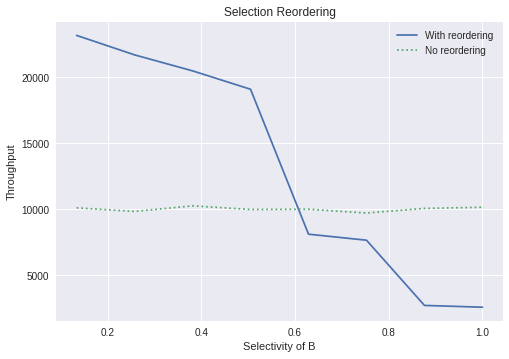

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(selectivity[1:], 47748 / np.array(thput_reorder)[1:], label='With reordering')
ax.plot(selectivity[1:], 47748 / np.array(thput_no_reorder)[1:], ':',label='No reordering')
ax.legend()
ax.set(xlabel='Selectivity of B', ylabel='Throughput',
       title='Selection Reordering')